<center><h1>第十章 时序数据</h1></center>

In [273]:
import numpy as np
import pandas as pd

## 一、时序中的基本对象

时间序列的概念在日常生活中十分常见，但对于一个具体的时序事件而言，可以从多个时间对象的角度来描述。例如2020年9月7日周一早上8点整需要到教室上课，这个课会在当天早上10点结束，其中包含了哪些时间概念？

* 第一，会出现时间戳（Date times）的概念，即'2020-9-7 08:00:00'和'2020-9-7 10:00:00'这两个时间点分别代表了上课和下课的时刻，在`pandas`中称为`Timestamp`。同时，一系列的时间戳可以组成`DatetimeIndex`，而将它放到`Series`中后，`Series`的类型就变为了`datetime64[ns]`，如果有涉及时区则为`datetime64[ns, tz]`，其中tz是timezone的简写。

* 第二，会出现时间差（Time deltas）的概念，即上课需要的时间，两个`Timestamp`做差就得到了时间差，pandas中利用`Timedelta`来表示。类似的，一系列的时间差就组成了`TimedeltaIndex`， 而将它放到`Series`中后，`Series`的类型就变为了`timedelta64[ns]`。

* 第三，会出现时间段（Time spans）的概念，即在8点到10点这个区间都会持续地在上课，在`pandas`利用`Period`来表示。类似的，一系列的时间段就组成了`PeriodIndex`， 而将它放到`Series`中后，`Series`的类型就变为了`Period`。

* 第四，会出现日期偏置（Date offsets）的概念，假设你只知道9月的第一个周一早上8点要去上课，但不知道具体的日期，那么就需要一个类型来处理此类需求。再例如，想要知道2020年9月7日后的第30个工作日是哪一天，那么时间差就解决不了你的问题，从而`pandas`中的`DateOffset`就出现了。同时，`pandas`中没有为一列时间偏置专门设计存储类型，理由也很简单，因为需求比较奇怪，一般来说我们只需要对一批时间特征做一个统一的特殊日期偏置。

通过这个简单的例子，就能够容易地总结出官方文档中的这个[表格](https://pandas.pydata.org/docs/user_guide/timeseries.html#overview)：

|概念 |                          单元素类型              |    数组类型         |                pandas数据类型|
|:---------|:----------|:-----------|:------------|
|Date times           |           `Timestamp`       |       `DatetimeIndex`  |   `datetime64[ns]`|
|Time deltas          |           `Timedelta`        |      `TimedeltaIndex` |  `timedelta64[ns]`|
|Time spans            |          `Period`           |      `PeriodIndex`   |    `period[freq]`|
|Date offsets          |          `DateOffset`         |    `None`          |    `None`|

由于时间段对象`Period/PeriodIndex`的使用频率并不高，因此将不进行讲解，而只涉及时间戳序列、时间差序列和日期偏置的相关内容。

## 二、时间戳
### 1. Timestamp的构造与属性

单个时间戳的生成利用`pd.Timestamp`实现，一般而言的常见日期格式都能被成功地转换：


In [274]:
ts = pd.Timestamp('2020/1/1')
ts

Timestamp('2020-01-01 00:00:00')

In [275]:
ts = pd.Timestamp('2020-1-1 08:10:30')
ts

Timestamp('2020-01-01 08:10:30')

通过`year, month, day, hour, min, second`可以获取具体的数值：

In [276]:
ts.year

2020

In [277]:
ts.month

1

In [278]:
ts.day

1

In [279]:
ts.hour

8

In [280]:
ts.minute

10

In [281]:
ts.second

30

在`pandas`中，时间戳的最小精度为纳秒`ns`，由于使用了64位存储，可以表示的时间范围大约可以如下计算：
$$\rm Time\,Range = \frac{2^{64}}{10^9\times 60\times 60\times 24\times 365} \approx 585 (Years)$$
通过`pd.Timestamp.max`和`pd.Timestamp.min`可以获取时间戳表示的范围，可以看到确实表示的区间年数大小正如上述计算结果：

In [282]:
pd.Timestamp.max

Timestamp('2262-04-11 23:47:16.854775807')

In [283]:
pd.Timestamp.min

Timestamp('1677-09-21 00:12:43.145225')

In [284]:
pd.Timestamp.max.year - pd.Timestamp.min.year

585

### 2. Datetime序列的生成

一组时间戳可以组成时间序列，可以用`to_datetime`和`date_range`来生成。其中，`to_datetime`能够把一列时间戳格式的对象转换成为`datetime64[ns]`类型的时间序列：

In [285]:
pd.to_datetime(['2020-1-1', '2020-1-3', '2020-1-6'])
df = pd.read_csv('../data/learn_pandas.csv')
s = pd.to_datetime(df.Test_Date)
s.head()

0   2019-10-05
1   2019-09-04
2   2019-09-12
3   2020-01-03
4   2019-11-06
Name: Test_Date, dtype: datetime64[ns]

在极少数情况，时间戳的格式不满足转换时，可以强制使用`format`进行匹配：

In [286]:
temp = pd.to_datetime(['2020\\1\\1','2020\\1\\3'],format='%Y\\%m\\%d')
temp

DatetimeIndex(['2020-01-01', '2020-01-03'], dtype='datetime64[ns]', freq=None)

注意上面由于传入的是列表，而非`pandas`内部的`Series`，因此返回的是`DatetimeIndex`，如果想要转为`datetime64[ns]`的序列，需要显式用`Series`转化：

In [287]:
pd.Series(temp).head()

0   2020-01-01
1   2020-01-03
dtype: datetime64[ns]

另外，还存在一种把表的多列时间属性拼接转为时间序列的`to_datetime`操作，此时的列名必须和以下给定的时间关键词列名一致：

In [288]:
df_date_cols = pd.DataFrame({'year': [2020, 2020],
                             'month': [1, 1],
                             'day': [1, 2],
                             'hour': [10, 20],
                             'minute': [30, 50],
                             'second': [20, 40]})
pd.to_datetime(df_date_cols)

0   2020-01-01 10:30:20
1   2020-01-02 20:50:40
dtype: datetime64[ns]

`date_range`是一种生成连续间隔时间的一种方法，其重要的参数为`start, end, freq, periods`，它们分别表示开始时间，结束时间，时间间隔，时间戳个数。其中，四个中的三个参数决定了，那么剩下的一个就随之确定了。这里要注意，开始或结束日期如果作为端点则它会被包含：

In [289]:
pd.date_range('2020-1-1','2020-1-21', freq='10D') # 包含

DatetimeIndex(['2020-01-01', '2020-01-11', '2020-01-21'], dtype='datetime64[ns]', freq='10D')

In [290]:
pd.date_range('2020-1-1','2020-2-28', freq='10D')

DatetimeIndex(['2020-01-01', '2020-01-11', '2020-01-21', '2020-01-31',
               '2020-02-10', '2020-02-20'],
              dtype='datetime64[ns]', freq='10D')

In [291]:
pd.date_range('2020-1-1', '2020-2-28', periods=6) # 由于结束日期无法取到，freq不为10天

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-12 14:24:00',
               '2020-01-24 04:48:00', '2020-02-04 19:12:00',
               '2020-02-16 09:36:00', '2020-02-28 00:00:00'],
              dtype='datetime64[ns]', freq=None)

这里的`freq`参数与`DateOffset`对象紧密相关，将在第四节介绍其具体的用法。
#### 【练一练】
`Timestamp`上定义了一个`value`属性，其返回的整数值代表了从1970年1月1日零点到给定时间戳相差的纳秒数，请利用这个属性构造一个随机生成给定日期区间内日期序列的函数。

In [641]:
def foo(date1, date2):
    delta1 = np.random.randint(pd.to_datetime(date1).value/(10e8*60*60*24), pd.to_datetime(date2).value/(10e8*60*60*24))
    delta2 = np.random.randint(delta1, pd.to_datetime(date2).value/(10e8*60*60*24))
    date3 = pd.Timestamp('19700101')+ pd.offsets.Day(delta1)
    date4 = pd.Timestamp('19700101')+ pd.offsets.Day(delta2)
    delta3 = np.random.randint(0, delta2-delta1)
    return pd.date_range(date3, date4, freq = str(delta3)+'D')

foo('19960101', '19980101')

DatetimeIndex(['1996-07-05', '1996-07-09', '1996-07-13', '1996-07-17',
               '1996-07-21', '1996-07-25', '1996-07-29', '1996-08-02',
               '1996-08-06', '1996-08-10', '1996-08-14', '1996-08-18',
               '1996-08-22', '1996-08-26', '1996-08-30'],
              dtype='datetime64[ns]', freq='4D')

#### 【END】
最后，要介绍一种改变序列采样频率的方法`asfreq`，它能够根据给定的`freq`对序列进行类似于`reindex`的操作：

In [292]:
s = pd.Series(np.random.rand(5), index=pd.to_datetime(['2020-1-%d'%i for i in range(1,10,2)]))
s.head()

2020-01-01    0.599639
2020-01-03    0.754960
2020-01-05    0.002285
2020-01-07    0.793186
2020-01-09    0.850937
dtype: float64

In [293]:
s.asfreq('D').head()

2020-01-01    0.599639
2020-01-02         NaN
2020-01-03    0.754960
2020-01-04         NaN
2020-01-05    0.002285
Freq: D, dtype: float64

In [294]:
s.asfreq('12H').head()

2020-01-01 00:00:00    0.599639
2020-01-01 12:00:00         NaN
2020-01-02 00:00:00         NaN
2020-01-02 12:00:00         NaN
2020-01-03 00:00:00    0.754960
Freq: 12H, dtype: float64

#### 【练一练】
前面提到了`datetime64[ns]`本质上可以理解为一个大整数，对于一个该类型的序列，可以使用`max, min, mean`，来取得最大时间戳、最小时间戳和“平均”时间戳。
#### 【END】
### 3. dt对象

如同`category, string`的序列上定义了`cat, str`来完成分类数据和文本数据的操作，在时序类型的序列上定义了`dt`对象来完成许多时间序列的相关操作。这里对于`datetime64[ns]`类型而言，可以大致分为三类操作：取出时间相关的属性、判断时间戳是否满足条件、取整操作。

第一类操作的常用属性包括：`date, time, year, month, day, hour, minute, second, microsecond, nanosecond, dayofweek, dayofyear, weekofyear, daysinmonth, quarter`，其中`daysinmonth, quarter`分别表示月中的第几天和季度。

In [295]:
s = pd.Series(pd.date_range('2020-1-1','2020-1-3', freq='D'))
s.dt.date

0    2020-01-01
1    2020-01-02
2    2020-01-03
dtype: object

In [296]:
s.dt.time

0    00:00:00
1    00:00:00
2    00:00:00
dtype: object

In [297]:
s.dt.day

0    1
1    2
2    3
dtype: int64

In [298]:
s.dt.daysinmonth

0    31
1    31
2    31
dtype: int64

在这些属性中，经常使用的是`dayofweek`，它返回了周中的星期情况，周一为0、周二为1，以此类推：

In [299]:
s.dt.dayofweek

0    2
1    3
2    4
dtype: int64

此外，可以通过`month_name, day_name`返回英文的月名和星期名，注意它们是方法而不是属性：

In [300]:
s.dt.month_name()

0    January
1    January
2    January
dtype: object

In [301]:
s.dt.day_name()

0    Wednesday
1     Thursday
2       Friday
dtype: object

第二类判断操作主要用于测试是否为月/季/年的第一天或者最后一天：

In [302]:
s.dt.is_year_start # 还可选 is_quarter/month_start

0     True
1    False
2    False
dtype: bool

In [303]:
s.dt.is_year_end # 还可选 is_quarter/month_end

0    False
1    False
2    False
dtype: bool

第三类的取整操作包含`round, ceil, floor`，它们的公共参数为`freq`，常用的包括`H, min, S`（小时、分钟、秒），所有可选的`freq`可参考[此处](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases>)。

In [304]:
s = pd.Series(pd.date_range('2020-1-1 20:35:00', '2020-1-1 22:35:00', freq='45min'))
s

0   2020-01-01 20:35:00
1   2020-01-01 21:20:00
2   2020-01-01 22:05:00
dtype: datetime64[ns]

In [305]:
s.dt.round('1H')

0   2020-01-01 21:00:00
1   2020-01-01 21:00:00
2   2020-01-01 22:00:00
dtype: datetime64[ns]

In [306]:
s.dt.ceil('1H')

0   2020-01-01 21:00:00
1   2020-01-01 22:00:00
2   2020-01-01 23:00:00
dtype: datetime64[ns]

In [307]:
s.dt.floor('1H')

0   2020-01-01 20:00:00
1   2020-01-01 21:00:00
2   2020-01-01 22:00:00
dtype: datetime64[ns]

### 4. 时间戳的切片与索引

一般而言，时间戳序列作为索引使用。如果想要选出某个子时间戳序列，第一类方法是利用`dt`对象和布尔条件联合使用，另一种方式是利用切片，后者常用于连续时间戳。下面，举一些例子说明：

In [308]:
s = pd.Series(np.random.randint(2,size=366), index=pd.date_range('2020-01-01','2020-12-31'))
idx = pd.Series(s.index).dt
s.head()

2020-01-01    0
2020-01-02    1
2020-01-03    1
2020-01-04    1
2020-01-05    0
Freq: D, dtype: int32

Example1：每月的第一天或者最后一天

In [309]:
s[(idx.is_month_start|idx.is_month_end).values].head()

2020-01-01    0
2020-01-31    0
2020-02-01    1
2020-02-29    0
2020-03-01    0
dtype: int32

Example2：双休日

In [310]:
s[idx.dayofweek.isin([5,6]).values].head()

2020-01-04    1
2020-01-05    0
2020-01-11    1
2020-01-12    1
2020-01-18    1
dtype: int32

Example3：取出单日值

In [311]:
s['2020-01-01']

0

In [312]:
s['20200101'] # 自动转换标准格式

0

Example4：取出七月

In [313]:
s['2020-07'].head()

2020-07-01    0
2020-07-02    1
2020-07-03    1
2020-07-04    0
2020-07-05    1
Freq: D, dtype: int32

Example5：取出5月初至7月15日

In [314]:
s['2020-05':'2020-7-15'].head()

2020-05-01    0
2020-05-02    1
2020-05-03    1
2020-05-04    1
2020-05-05    0
Freq: D, dtype: int32

In [315]:
s['2020-05':'2020-7-15'].tail()

2020-07-11    1
2020-07-12    0
2020-07-13    1
2020-07-14    1
2020-07-15    1
Freq: D, dtype: int32

## 三、时间差
### 1. Timedelta的生成

正如在第一节中所说，时间差可以理解为两个时间戳的差，这里也可以通过`pd.Timedelta`来构造：

In [316]:
pd.Timestamp('20200102 08:00:00')-pd.Timestamp('20200101 07:35:00')

Timedelta('1 days 00:25:00')

In [317]:
pd.Timedelta(days=1, minutes=25) # 需要注意加s

Timedelta('1 days 00:25:00')

In [318]:
pd.Timedelta('1 days 25 minutes') # 字符串生成

Timedelta('1 days 00:25:00')

生成时间差序列的主要方式是`pd.to_timedelta`，其类型为`timedelta64[ns]`：

In [319]:
s = pd.to_timedelta(df.Time_Record)
s.head()

0   0 days 00:04:34
1   0 days 00:04:20
2   0 days 00:05:22
3   0 days 00:04:08
4   0 days 00:05:22
Name: Time_Record, dtype: timedelta64[ns]

与`date_range`一样，时间差序列也可以用`timedelta_range`来生成，它们两者具有一致的参数：

In [320]:
pd.timedelta_range('0s', '1000s', freq='6min')

TimedeltaIndex(['0 days 00:00:00', '0 days 00:06:00', '0 days 00:12:00'], dtype='timedelta64[ns]', freq='6T')

In [321]:
pd.timedelta_range('0s', '1000s', periods=3)

TimedeltaIndex(['0 days 00:00:00', '0 days 00:08:20', '0 days 00:16:40'], dtype='timedelta64[ns]', freq=None)

对于`Timedelta`序列，同样也定义了`dt`对象，上面主要定义了的属性包括`days, seconds, mircroseconds, nanoseconds`，它们分别返回了对应的时间差特征。需要注意的是，这里的`seconds`不是指单纯的秒，而是对天数取余后剩余的秒数：

In [322]:
s.dt.seconds.head()

0    274
1    260
2    322
3    248
4    322
Name: Time_Record, dtype: int64

如果不想对天数取余而直接对应秒数，可以使用`total_seconds`

In [323]:
s.dt.total_seconds().head()

0    274.0
1    260.0
2    322.0
3    248.0
4    322.0
Name: Time_Record, dtype: float64

与时间戳序列类似，取整函数也是可以在`dt`对象上使用的：

In [324]:
pd.to_timedelta(df.Time_Record).dt.round('min').head()

0   0 days 00:05:00
1   0 days 00:04:00
2   0 days 00:05:00
3   0 days 00:04:00
4   0 days 00:05:00
Name: Time_Record, dtype: timedelta64[ns]

### 2. Timedelta的运算

时间差支持的常用运算有三类：与标量的乘法运算、与时间戳的加减法运算、与时间差的加减法与除法运算：

In [325]:
td1 = pd.Timedelta(days=1)
td2 = pd.Timedelta(days=3)
ts = pd.Timestamp('20200101')
td1 * 2

Timedelta('2 days 00:00:00')

In [326]:
td2 - td1

Timedelta('2 days 00:00:00')

In [327]:
ts + td1

Timestamp('2020-01-02 00:00:00')

In [328]:
ts - td1

Timestamp('2019-12-31 00:00:00')

这些运算都可以移植到时间差的序列上：

In [329]:
td1 = pd.timedelta_range(start='1 days', periods=5)
td2 = pd.timedelta_range(start='12 hours', freq='2H', periods=5)
ts = pd.date_range('20200101', '20200105')
td1 * 5

TimedeltaIndex(['5 days', '10 days', '15 days', '20 days', '25 days'], dtype='timedelta64[ns]', freq='5D')

In [330]:
td1 * pd.Series(list(range(5))) # 逐个相乘

0    0 days
1    2 days
2    6 days
3   12 days
4   20 days
dtype: timedelta64[ns]

In [331]:
td1 - td2

TimedeltaIndex(['0 days 12:00:00', '1 days 10:00:00', '2 days 08:00:00',
                '3 days 06:00:00', '4 days 04:00:00'],
               dtype='timedelta64[ns]', freq=None)

In [332]:
td1 + pd.Timestamp('20200101')

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06'],
              dtype='datetime64[ns]', freq='D')

In [333]:
td1 + ts # 逐个相加

DatetimeIndex(['2020-01-02', '2020-01-04', '2020-01-06', '2020-01-08',
               '2020-01-10'],
              dtype='datetime64[ns]', freq=None)

## 四、日期偏置
### 1. Offset对象

日期偏置是一种和日历相关的特殊时间差，例如回到第一节中的两个问题：如何求2020年9月第一个周一的日期，以及如何求2020年9月7日后的第30个工作日是哪一天。

In [334]:
pd.Timestamp('20200831') + pd.offsets.WeekOfMonth(week=0,weekday=0)

Timestamp('2020-09-07 00:00:00')

In [335]:
pd.Timestamp('20200907') + pd.offsets.BDay(30)

Timestamp('2020-10-19 00:00:00')

从上面的例子中可以看到，`Offset`对象在`pd.offsets`中被定义。当使用`+`时获取离其最近的下一个日期，当使用`-`时获取离其最近的上一个日期：

In [336]:
pd.Timestamp('20200831') - pd.offsets.WeekOfMonth(week=0,weekday=0)

Timestamp('2020-08-03 00:00:00')

In [337]:
pd.Timestamp('20200907') - pd.offsets.BDay(30)

Timestamp('2020-07-27 00:00:00')

In [338]:
pd.Timestamp('20200907') + pd.offsets.MonthEnd()

Timestamp('2020-09-30 00:00:00')

常用的日期偏置如下可以查阅这里的[文档](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects)描述。在文档罗列的`Offset`中，需要介绍一个特殊的`Offset`对象`CDay`，其中的`holidays, weekmask`参数能够分别对自定义的日期和星期进行过滤，前者传入了需要过滤的日期列表，后者传入的是三个字母的星期缩写构成的星期字符串，其作用是只保留字符串中出现的星期：

In [339]:
my_filter = pd.offsets.CDay(n=1,weekmask='Wed Fri',holidays=['20200109'])
dr = pd.date_range('20200108', '20200111')
dr.to_series().dt.dayofweek

2020-01-08    2
2020-01-09    3
2020-01-10    4
2020-01-11    5
Freq: D, dtype: int64

In [340]:
[i + my_filter for i in dr]

[Timestamp('2020-01-10 00:00:00'),
 Timestamp('2020-01-10 00:00:00'),
 Timestamp('2020-01-15 00:00:00'),
 Timestamp('2020-01-15 00:00:00')]

上面的例子中，`n`表示增加一天`CDay`，`dr`中的第一天为`20200108`，但由于下一天`20200109`被排除了，并且`20200110`是合法的周五，因此转为`20200110`，其他后面的日期处理类似。
#### 【CAUTION】不要使用部分`Offset`
在当前版本下由于一些 ``bug`` ，不要使用 ``Day`` 级别以下的 ``Offset`` 对象，比如 ``Hour, Second`` 等，请使用对应的 ``Timedelta`` 对象来代替。
#### 【END】
### 2. 偏置字符串

前面提到了关于`date_range`的`freq`取值可用`Offset`对象，同时在`pandas`中几乎每一个`Offset`对象绑定了日期偏置字符串（`frequencies strings/offset aliases`），可以指定`Offset`对应的字符串来替代使用。下面举一些常见的例子。

In [341]:
pd.date_range('20200101','20200331', freq='MS') # 月初

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq='MS')

In [342]:
pd.date_range('20200101','20200331', freq='M') # 月末

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')

In [343]:
pd.date_range('20200101','20200110', freq='B') # 工作日

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', freq='B')

In [344]:
pd.date_range('20200101','20200201', freq='W-MON') # 周一

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27'], dtype='datetime64[ns]', freq='W-MON')

In [345]:
pd.date_range('20200101','20200201', freq='WOM-1MON') # 每月第一个周一

DatetimeIndex(['2020-01-06'], dtype='datetime64[ns]', freq='WOM-1MON')

上面的这些字符串，等价于使用如下的`Offset`对象：

In [346]:
pd.date_range('20200101','20200331', freq=pd.offsets.MonthBegin())

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq='MS')

In [347]:
pd.date_range('20200101','20200331', freq=pd.offsets.MonthEnd())

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')

In [348]:
pd.date_range('20200101','20200110', freq=pd.offsets.BDay())

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', freq='B')

In [349]:
pd.date_range('20200101','20200201', freq=pd.offsets.CDay(weekmask='Mon'))

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27'], dtype='datetime64[ns]', freq='C')

In [350]:
pd.date_range('20200101','20200201', freq=pd.offsets.WeekOfMonth(week=0,weekday=0))

DatetimeIndex(['2020-01-06'], dtype='datetime64[ns]', freq='WOM-1MON')

#### 【CAUTION】关于时区问题的说明
各类时间对象的开发，除了使用`python`内置的`datetime`模块，`pandas`还利用了`dateutil`模块，很大一部分是为了处理时区问题。总所周知，我国是没有夏令时调整时间一说的，但有些国家会有这种做法，导致了相对而言一天里可能会有23/24/25个小时，也就是`relativedelta`，这使得`Offset`对象和`Timedelta`对象有了对同一问题处理产生不同结果的现象，其中的规则也较为复杂，官方文档的写法存在部分描述错误，并且难以对描述做出统一修正，因为牵涉到了`Offset`相关的很多组件。因此，本教程完全不考虑时区处理，如果对时区处理的时间偏置有兴趣了解讨论，可以联系我或者参见[这里](https://github.com/pandas-dev/pandas/pull/36516)的讨论。
#### 【END】
## 五、时序中的滑窗与分组
### 1. 滑动窗口

所谓时序的滑窗函数，即把滑动窗口用`freq`关键词代替，下面给出一个具体的应用案例：在股票市场中有一个指标为`BOLL`指标，它由中轨线、上轨线、下轨线这三根线构成，具体的计算方法分别是`N`日均值线、`N`日均值加两倍`N`日标准差线、`N`日均值减两倍`N`日标准差线。利用`rolling`对象计算`N=30`的`BOLL`指标可以如下写出：

In [351]:
import matplotlib.pyplot as plt
idx = pd.date_range('20200101', '20201231', freq='B')
np.random.seed(2020)
data = np.random.randint(-1,2,len(idx)).cumsum() # 随机游动构造模拟序列
s = pd.Series(data,index=idx)
s.head()

2020-01-01   -1
2020-01-02   -2
2020-01-03   -1
2020-01-06   -1
2020-01-07   -2
Freq: B, dtype: int32

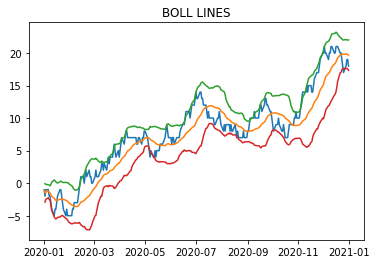

In [352]:
r = s.rolling('30D')
plt.plot(s)
plt.title('BOLL LINES')
plt.plot(r.mean())
plt.plot(r.mean()+r.std()*2)
plt.plot(r.mean()-r.std()*2)

对于`shift`函数而言，作用在`datetime64`为索引的序列上时，可以指定`freq`单位进行滑动：

In [353]:
s.shift(freq='50D').head()

2020-02-20   -1
2020-02-21   -2
2020-02-22   -1
2020-02-25   -1
2020-02-26   -2
dtype: int32

另外，`datetime64[ns]`的序列进行`diff`后就能够得到`timedelta64[ns]`的序列，这能够使用户方便地观察有序时间序列的间隔：

In [354]:
my_series = pd.Series(s.index)
my_series.head()

0   2020-01-01
1   2020-01-02
2   2020-01-03
3   2020-01-06
4   2020-01-07
dtype: datetime64[ns]

In [355]:
my_series.diff(1).head()

0      NaT
1   1 days
2   1 days
3   3 days
4   1 days
dtype: timedelta64[ns]

### 2. 重采样

重采样对象`resample`和第四章中分组对象`groupby`的用法类似，前者是针对时间序列的分组计算而设计的分组对象。

例如，对上面的序列计算每10天的均值：

In [356]:
s.resample('10D').mean().head()

2020-01-01   -2.000000
2020-01-11   -3.166667
2020-01-21   -3.625000
2020-01-31   -4.000000
2020-02-10   -0.375000
Freq: 10D, dtype: float64

同时，如果没有内置定义的处理函数，可以通过`apply`方法自定义：

In [357]:
s.resample('10D').apply(lambda x:x.max()-x.min()).head() # 极差

2020-01-01    3
2020-01-11    4
2020-01-21    4
2020-01-31    2
2020-02-10    4
Freq: 10D, dtype: int32

在`resample`中要特别注意组边界值的处理情况，默认情况下起始值的计算方法是从最小值时间戳对应日期的午夜`00:00:00`开始增加`freq`，直到不超过该最小时间戳的最大时间戳，由此对应的时间戳为起始值，然后每次累加`freq`参数作为分割结点进行分组，区间情况为左闭右开。下面构造一个不均匀的例子：

In [358]:
idx = pd.date_range('20200101 8:26:35', '20200101 9:31:58', freq='77s')
data = np.random.randint(-1,2,len(idx)).cumsum()
s = pd.Series(data,index=idx)
s.head()

2020-01-01 08:26:35   -1
2020-01-01 08:27:52   -1
2020-01-01 08:29:09   -2
2020-01-01 08:30:26   -3
2020-01-01 08:31:43   -4
Freq: 77S, dtype: int32

下面对应的第一个组起始值为`08:24:00`，其是从当天0点增加72个`freq=7 min`得到的，如果再增加一个`freq`则超出了序列的最小时间戳`08:26:35`：

In [359]:
s.resample('7min').mean().head()

2020-01-01 08:24:00   -1.750000
2020-01-01 08:31:00   -2.600000
2020-01-01 08:38:00   -2.166667
2020-01-01 08:45:00    0.200000
2020-01-01 08:52:00    2.833333
Freq: 7T, dtype: float64

08：24对应的平均值是s中\[08:24,08:31)区间内的前四个时间点对应的1，1，0，1的平均值

有时候，用户希望从序列的最小时间戳开始依次增加`freq`进行分组，此时可以指定`origin`参数为`start`：

In [360]:
s.resample('7min', origin='start').mean().head()

2020-01-01 08:26:35   -2.333333
2020-01-01 08:33:35   -2.400000
2020-01-01 08:40:35   -1.333333
2020-01-01 08:47:35    1.200000
2020-01-01 08:54:35    3.166667
Freq: 7T, dtype: float64

在返回值中，要注意索引一般是取组的第一个时间戳，但`M, A, Q, BM, BA, BQ, W`这七个是取对应区间的最后一个时间戳：

In [361]:
s = pd.Series(np.random.randint(2,size=366), index=pd.date_range('2020-01-01', '2020-12-31'))
s.resample('M').mean().head()

2020-01-31    0.451613
2020-02-29    0.448276
2020-03-31    0.516129
2020-04-30    0.566667
2020-05-31    0.451613
Freq: M, dtype: float64

In [362]:
s.resample('MS').mean().head() # 结果一样，但索引不同

2020-01-01    0.451613
2020-02-01    0.448276
2020-03-01    0.516129
2020-04-01    0.566667
2020-05-01    0.451613
Freq: MS, dtype: float64

## 六、练习
### Ex1：太阳辐射数据集

现有一份关于太阳辐射的数据集：

In [363]:
df = pd.read_csv('../data/solar.csv', usecols=['Data','Time','Radiation','Temperature'])
df.head(3)

,Data,Time,Radiation,Temperature
0,9/29/2016 12:00:00 AM,23:55:26,1.21,48
1,9/29/2016 12:00:00 AM,23:50:23,1.21,48
2,9/29/2016 12:00:00 AM,23:45:26,1.23,48


1. 将`Datetime, Time`合并为一个时间列`Datetime`，同时把它作为索引后排序。

In [364]:
df['Datetime'] = pd.to_datetime(df.Data) + pd.to_timedelta(df.Time)
df = df.set_index('Datetime').sort_index()

2. 每条记录时间的间隔显然并不一致，请解决如下问题：
* 找出间隔时间的前三个最大值所对应的三组时间戳。
* 是否存在一个大致的范围，使得绝大多数的间隔时间都落在这个区间中？如果存在，请对此范围内的样本间隔秒数画出柱状图，设置`bins=50`。

In [365]:
s = pd.Series(df.index)

In [366]:
# 输出间隔时间前三个最大值所对应的三组时间戳
for i in s.diff().sort_values(ascending = False).head(3).index:
    print(s[i-1:i+1])

25922   2016-12-05 20:45:53
25923   2016-12-08 11:10:42
Name: Datetime, dtype: datetime64[ns]
24521   2016-11-29 19:05:02
24522   2016-12-01 00:00:02
Name: Datetime, dtype: datetime64[ns]
7416   2016-09-29 23:55:26
7417   2016-10-01 00:00:19
Name: Datetime, dtype: datetime64[ns]


In [367]:
from matplotlib import pyplot as plt

In [368]:
s_ = s.diff().dropna().dt.total_seconds()

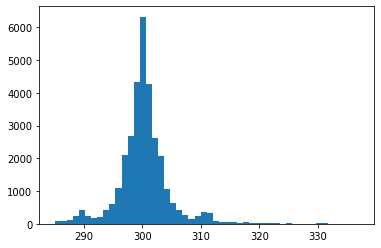

In [369]:
_ = plt.hist(s_.mask((s_>s_.quantile(0.99))|(s_<s_.quantile(0.01))).dropna(), bins = 50)

3. 求如下指标对应的`Series`：
* 温度与辐射量的6小时滑动相关系数
* 以三点、九点、十五点、二十一点为分割，该观测所在时间区间的温度均值序列
* 每个观测6小时前的辐射量（一般而言不会恰好取到，此时取最近时间戳对应的辐射量）

In [370]:
res = df.Radiation.rolling('6H').corr(df.Temperature)
res.tail()

Datetime
2016-12-31 23:35:02    0.416187
2016-12-31 23:40:01    0.416565
2016-12-31 23:45:04    0.328574
2016-12-31 23:50:03    0.261883
2016-12-31 23:55:01    0.262406
dtype: float64

In [371]:
res = df.resample('6H', origin = '03:00').mean()
res.head()

,Radiation,Temperature
Datetime,,
2016-08-31 21:00:00,2.700937,51.218750
2016-09-01 03:00:00,85.144167,50.033333
2016-09-01 09:00:00,943.123621,59.379310
2016-09-01 15:00:00,228.577969,57.984375
2016-09-01 21:00:00,2.507576,51.393939


In [372]:
my_dt = df.index.shift(freq='-6H') # 取六小时前的时间戳
int_loc = [df.index.get_loc(i, method='nearest') for i in my_dt] # 距离六小时前最近的时间戳
res = df.Radiation.iloc[int_loc] # 取int_loc对应的辐射量
res.tail(3)

Datetime
2016-12-31 17:45:02    9.33
2016-12-31 17:50:01    8.49
2016-12-31 17:55:02    5.84
Name: Radiation, dtype: float64

### Ex2：水果销量数据集

现有一份2019年每日水果销量记录表：

In [373]:
df = pd.read_csv('../data/fruit.csv')
df.head(3)

,Date,Fruit,Sale
0,2019-04-18,Peach,15
1,2019-12-29,Peach,15
2,2019-06-05,Peach,19


1. 统计如下指标：
* 每月上半月（15号及之前）与下半月葡萄销量的比值
* 每月最后一天的生梨销量总和
* 每月最后一天工作日的生梨销量总和
* 每月最后五天的苹果销量均值
2. 按月计算周一至周日各品种水果的平均记录条数，行索引外层为水果名称，内层为月份，列索引为星期。
3. 按天计算向前10个工作日窗口的苹果销量均值序列，非工作日的值用上一个工作日的结果填充。


In [446]:
# 每月上半月（15号及之前）与下半月葡萄销量的比值

df.Date = pd.to_datetime(df.Date)
df_p = df[df['Fruit']== 'Grape']
res = df_p.groupby([np.where(df_p.Date.dt.day<=15, 'First', 'Second'),
              df_p.Date.dt.month])['Sale'].mean().to_frame().unstack(0).droplevel(0, axis = 1)
res = (res.First/res.Second).rename_axis('Month')

In [432]:
df.Fruit.unique()

array(['Peach', 'Pear', 'Grape', 'Banana', 'Apple'], dtype=object)

In [486]:
# 每月最后一天的生梨销量总和

df_pear = df[df.Fruit == 'Pear']

date_range = pd.date_range(df_pear.Date.min(), df_pear.Date.max(), freq = 'M') # 构造月末的时间序列

df_pear[df_pear.Date.isin(date_range)].groupby('Date')['Sale'].sum().head() # 每天求和

Date
2019-01-31    847
2019-02-28    774
2019-03-31    761
2019-04-30    648
2019-05-31    616
Name: Sale, dtype: int64

In [453]:
# 每月最后五天的苹果销量均值

In [485]:
df_a = df[df.Fruit == 'Apple']
# 按月聚合，取出最大的5天
dt = df.drop_duplicates().groupby(df.Date.drop_duplicates().dt.month)['Date'].nlargest(5).reset_index(drop=True)

df_a[df_a.Date.isin(dt)].groupby(df_a.Date.dt.month)['Sale'].mean().head()

Date
1    65.313725
2    54.061538
3    59.325581
4    65.795455
5    57.465116
Name: Sale, dtype: float64

In [487]:
# 2. 按月计算周一至周日各品种水果的平均记录条数，行索引外层为水果名称，内层为月份，列索引为星期。

In [504]:
res = df.groupby([df.Fruit,df.Date.dt.month, df.Date.dt.day_name()])['Sale'].count().to_frame()
res.index.names = ['Fruit', 'month', 'day_name']
res = res.reset_index().pivot(index = ['Fruit', 'month'], columns = 'day_name', values = 'Sale')
res = res[['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']]

In [543]:
res.head()

day_name     Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Fruit month                                                                
Apple 1          46       50         50        45      32        42      23
      2          43       40         47        35      33        38      45
      3          43       44         37        31      52        42      42
      4          47       52         43        47      31        35      37
      5          43       46         39        58      46        55      31

In [544]:
# 3. 按天计算向前10个工作日窗口的苹果销量均值序列，非工作日的值用上一个工作日的结果填充。

In [592]:
# 取出工作日苹果销量记录
df_ab = df_a[~df_a.Date.dt.dayofweek.isin([5,6])]

# 计算工作日滑动均值
s = pd.Series(df_ab.Sale.values, index = df_ab.Date).groupby('Date').sum()
res = s.rolling('10D').mean().asfreq('D').fillna(method = 'ffill')
res.head()

Date
2019-01-01    189.000000
2019-01-02    335.500000
2019-01-03    520.333333
2019-01-04    527.750000
2019-01-05    527.750000
Freq: D, dtype: float64